In [4]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_curve, 
    auc, 
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM, 
    Dense, 
    Masking, 
    BatchNormalization, 
    Dropout, 
    Flatten, 
    TimeDistributed
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import Accuracy, Precision, Recall

import tensorflow as tf

# Seaborn theme setting
sns.set_theme(font_scale=1.5)

In [5]:
def get_label_from_filename(filename):
    labels_dir = '../../../Data/Labels'
    id = int(filename.split('_')[0])
    for filename in os.listdir(labels_dir):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(labels_dir, filename))
            if id in df['Participant_ID'].values:
                label = df[df['Participant_ID'] == id]['PHQ8_Binary'].values[0]
                break
    return label

# Ruta a los archivos CSV
data_dir = '../../../Results/Final/Audio_features'

# Cargar los CSV y almacenar los datos MFCC y etiquetas
mfcc_sequences = []
labels = []

for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_dir, filename)
        mfcc = pd.read_csv(file_path).values

        # Estandarizar las columnas (features) de MFCC
        scaler = StandardScaler()
        mfcc = scaler.fit_transform(mfcc)

        mfcc_sequences.append(mfcc)

        # Obtener etiqueta del nombre del archivo o un archivo separado
        label = get_label_from_filename(filename)
        labels.append(label)

# Encontrar la longitud máxima de las secuencias
max_length = max(len(seq) for seq in mfcc_sequences)

# Rellenar las secuencias con ceros
padded_mfcc_sequences = pad_sequences(mfcc_sequences, maxlen=max_length, dtype='float32', padding='post')

# Convertir etiquetas a binario (opcional: one-hot encoding)
labels = np.array(labels)

In [6]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(padded_mfcc_sequences, labels, test_size=0.3, random_state=42)
print(X_train.shape)
print(y_train.shape)

(128, 38557, 60)
(128,)


In [7]:
def resample_data(X_train, y_train, method='none', random_state=42):
    """
    Resample the training data based on the specified method.

    Parameters:
    - X_train: np.array, training data features.
    - y_train: np.array, training data labels.
    - method: str, resampling method - 'undersample', 'oversample', or 'none'.
    - random_state: int, random state for reproducibility.

    Returns:
    - X_train_resampled: np.array, resampled training data features.
    - y_train_resampled: np.array, resampled training data labels (categorical).
    """
    
    if method == 'undersample':
        rus = RandomUnderSampler(random_state=random_state)
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
        X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])
    elif method == 'oversample':
        ros = RandomOverSampler(random_state=random_state)
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
        X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
    
    y_train_resampled = to_categorical(y_train_resampled)
    
    return X_train_resampled, y_train_resampled

In [8]:
# Ejemplo de uso:
X_train_resampled, y_train_resampled = resample_data(X_train, y_train, method='undersample')
print('X_train_resampled shape:', X_train_resampled.shape)
print('y_train_resampled shape:', y_train_resampled.shape)
print('y_train_resampled distribution:', np.bincount(np.argmax(y_train_resampled, axis=1)))

X_train_resampled shape: (72, 38557, 60)
y_train_resampled shape: (72, 2)
y_train_resampled distribution: [36 36]


In [9]:
# Regularization L1 y L2
regularizer = l1_l2(l1=0.0001, l2=0.0001)

# Learning rate scheduling
initial_learning_rate = 1e-3
decay_rate = 1e-6

# Function to schedule the learning rate
def scheduler(epoch, lr):
    return initial_learning_rate * (1 / (1 + decay_rate * epoch))

# Create the model
model_audio = Sequential()

# Masking Layer
model_audio.add(Masking(mask_value=0., input_shape=(max_length, X_train.shape[2])))

# First layer of the LSTM
model_audio.add(LSTM(
    units=60,
    activation='tanh',
    recurrent_activation='sigmoid',
    kernel_initializer=glorot_uniform(),
    return_sequences=True
))
model_audio.add(BatchNormalization())
model_audio.add(Dropout(0.02))

# Second Layer of the LSTM
model_audio.add(LSTM(
    units=40,
    activation='tanh',
    recurrent_activation='sigmoid',
    kernel_initializer=glorot_uniform(),
    return_sequences=True
))
model_audio.add(BatchNormalization())
model_audio.add(Dropout(0.02))

# Third layer of the LSTM
model_audio.add(LSTM(
    units=20,
    activation='tanh',
    recurrent_activation='sigmoid',
    kernel_initializer=glorot_uniform()
))
model_audio.add(BatchNormalization())
model_audio.add(Dropout(0.02))

# Flatten layer
model_audio.add(Flatten())

# First dense layer
model_audio.add(Dense(15, activation='tanh'))
model_audio.add(BatchNormalization())
model_audio.add(Dropout(0.02))

# Second dense layer
model_audio.add(Dense(10, activation='tanh'))
model_audio.add(BatchNormalization())
model_audio.add(Dropout(0.02))

# Output layer
model_audio.add(Dense(2, activation='sigmoid'))

# Compile the model with the optimizer, loss function and metrics
model_audio.compile(optimizer=RMSprop(learning_rate=initial_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()]  # Métricas de clasificación
              )

# Definir el callback para el learning rate scheduling
lr_scheduler = LearningRateScheduler(scheduler)

# Show the model summary
model_audio.summary()

c:\Users\AdrianLopez\anaconda3\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 38557, 60)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 38557, 60)      │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38557, 60)      │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38557, 60)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 38557, 40)      │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 38557, 40)      │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38557, 40)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20)             │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,157 (199.83 KB)

 Trainable params: 50,867 (198.70 KB)

 Non-trainable params: 290 (1.13 KB)

In [10]:
# Load weights
weights_path = 'audio_weights_undersampled.h5'
model_audio.load_weights(weights_path)

# Load history
with open('training_history_undersampled.json', 'r') as f:
    history = json.load(f)

In [11]:
# To categorical
y_test = to_categorical(y_test)

# Print shapes 
print(X_test.shape)
print(y_test.shape)

(56, 38557, 60)
(56, 2)


In [12]:
model_audio.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.5923 - loss: 2.5954 - precision: 0.5828 - recall: 0.5699


[2.4987974166870117,
 0.6071428656578064,
 0.6000000238418579,
 0.5892857313156128]

In [13]:
# Confusion matrix
y_pred_prob = model_audio.predict(X_test)
y_true = np.argmax(y_test, axis=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step


In [14]:
def evaluate_classification_model(y_pred_prob, y_true):
    # Ensure the input arrays are numpy arrays
    y_pred_prob = np.array(y_pred_prob)
    y_true = np.array(y_true)
    
    # Obtaining the predicted probabilities for the positive class
    y_pred_prob_positive = y_pred_prob[:, 1]
    
    # Roc curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob_positive)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Undersampled Audio ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Predict the class labels
    y_pred = (y_pred_prob_positive >= 0.5).astype(int)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax)

    # Remove gridlines and labels
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    # Adjust the colorbar ticks
    cbar = ax.images[-1].colorbar
    cbar.set_ticks(range(int(cm.min()), int(cm.max()) + 1,4))

    plt.title('Confusion Matrix')    
    plt.show()
    
    # Classification report
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print('Classification Report:\n', report)


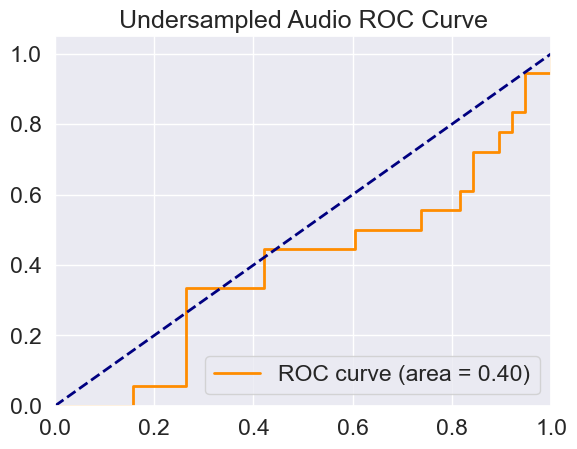

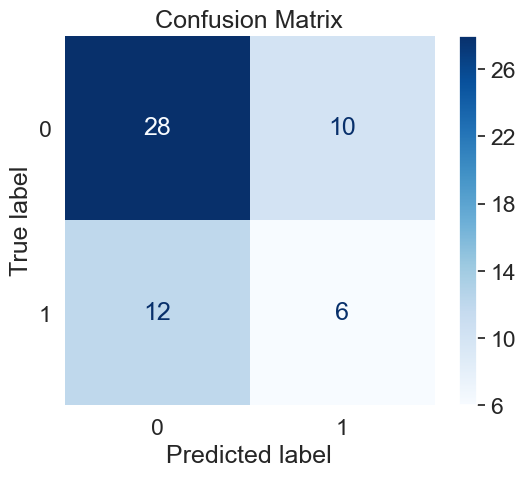

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.70      0.74      0.72        38
     Class 1       0.38      0.33      0.35        18

    accuracy                           0.61        56
   macro avg       0.54      0.54      0.54        56
weighted avg       0.60      0.61      0.60        56



In [15]:
evaluate_classification_model(y_pred_prob, y_true)